In [1]:
from torchsat.models.segmentation.unet import UNetResNet

import rasterio as rio
import numpy as np
import os, sys
# add the unet helpers
sys.path.append('../../')
# from test_unet_helpers import *
from utils import variable
from unet_models import unet11_MS

import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json
from torch import nn
import torch
import torch.nn.functional as F

from glob import glob
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, precision_recall_fscore_support

In [2]:
class DG_GT_Dataset(Dataset):
    """Dataset class DG and GT data"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None, rot=False):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        self.rot = rot
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()
            
        #print(img_arr.shape, gt_arr.shape)

        # first consider the rotation argument
        if self.rot:
            dg_t = torch.from_numpy(img_arr)
            gt_t = torch.from_numpy(gt_arr)
            
            # get a random number
            rot_p = np.random.random()*100
            
            # do nothing
            if rot_p < 15:
                
                return (dg_t, gt_t)
            
            elif (rot_p >= 15) and (rot_p < 50):
                
                dg_rot = dg_t.transpose(1,2)
                gt_rot = gt_t.transpose(1,2)
                
                return (dg_rot, gt_t)
            
            elif (rot_p >= 50) and (rot_p < 75):
                
                dg_rot = dg_t.flip(1).flip(2)
                gt_rot = gt_t.flip(1).flip(2)
                
                return (dg_rot, gt_rot)
                
            else:
            
                dg_rot = dg_t.transpose(1,2).flip(2) #t90 CCW
                gt_rot = gt_t.transpose(1,2).flip(2)
                
                return(dg_rot, gt_rot)
            


        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
            
        
    def __len__(self):
        return len(self.img_files)

In [3]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

In [4]:
torch.manual_seed(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True

In [5]:
# aws paths
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgr')
ps_train_ds_rot = DG_GT_Dataset(train_folder, channels='bgr', rot=True)

ps_test_ds = DG_GT_Dataset(test_folder, channels='bgr')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgr')

../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt_is_00500.tif


In [6]:
# iterate over some batch sizes
times = []

# set some parameters
lr = 0.001
bsize = 32 # was 32

ps_model = UNetResNet(encoder_depth=152, num_classes=1, in_channels=3, num_filters=32, dropout_2d=0.2,
                 pretrained=False, is_deconv=True)

ps_optimizer = Adam(ps_model.parameters(), lr=lr)
ps_criterion = LossBinary(jaccard_weight=1.0)

###### specify DataLoaders
n_workers=torch.cuda.device_count()*2
ps_train_rot_dl = DataLoader(ps_train_ds_rot, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_test_dl = DataLoader(ps_test_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)


# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    ps_model = nn.DataParallel(ps_model)
    ps_model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    print('made cpu parallel')

Let's use 4 GPUs!


In [7]:
 torch.cuda.device_count()

4

In [8]:
print('batchsize, ', bsize)
ps_mean_loss = 0.0
ps_running_loss = 0.0
print('training...')

ps_losses=[]
ps_losses_ep = []
ps_step=0

# record time for one epoch
ps_rocs = []
ps_f1 = []
ps_prec = []
ps_recall = []
ps_f1_ep = []
ps_mAP_ep = []
ps_mAR_ep = []

#####################################################

t0 = time.time()
num_epochs = 500
ctr=0
ps_model.train()
for epoch in range(num_epochs):
    

    te = time.time()

    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))

    running_loss = 0
    
        
    _ps_rocs = []
    _ps_f1 = []
    _ps_prec = []
    _ps_recall = []
    for i, (inputs_, targets_) in enumerate(ps_train_rot_dl):

        #print('hi')

        # get the inputs
        targets_ = targets_.type(torch.FloatTensor)

        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = ps_model(inputs)

        # zero parameter gradients
        ps_optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = ps_criterion(outputs, targets)
        i_loss.backward()
        ps_optimizer.step()
        ps_step+=1

        running_loss += i_loss

        #record iterations f1, precision, recall
        _f1 = f1_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0., average='binary')
        _ps_f1.append(_f1)
        _prec = precision_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
        _ps_prec.append(_prec)
        _recall = recall_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
        _ps_recall.append(_recall)

        if i%5 == 0: # print/store every 5
            ps_losses.append(i_loss)
            

    # append precision and recall metrics
    ps_f1 += _ps_f1
    ps_prec += _ps_prec
    ps_recall += _ps_recall

    ps_f1_ep.append(np.mean(_ps_f1))
    ps_mAP_ep.append(np.mean(_ps_prec))
    ps_mAR_ep.append(np.mean(_ps_recall))

    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
        ps_rocs.append(tu[1])


    ps_losses_ep.append(running_loss)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

        

        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

batchsize,  32
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


time for epoch 1: 39.53886651992798 seconds
on epoch 2
epoch: 2, LOSS=1.4354069232940674, ROC_AUC=0.561797312284716 
time for epoch 2: 30.042800903320312 seconds
on epoch 3
time for epoch 3: 29.645706176757812 seconds
on epoch 4
epoch: 4, LOSS=1.3032371997833252, ROC_AUC=0.67096900795826 
time for epoch 4: 30.65725588798523 seconds
on epoch 5
time for epoch 5: 30.397435426712036 seconds
on epoch 6
epoch: 6, LOSS=1.225570797920227, ROC_AUC=0.692422423064515 
time for epoch 6: 30.510992288589478 seconds
on epoch 7
time for epoch 7: 29.867077827453613 seconds
on epoch 8
epoch: 8, LOSS=1.2484021186828613, ROC_AUC=0.6812736571581961 
time for epoch 8: 30.39846396446228 seconds
on epoch 9
time for epoch 9: 30.434895753860474 seconds
on epoch 10
epoch: 10, LOSS=1.2653995752334595, ROC_AUC=0.6793424020384187 
time for epoch 10: 30.738929510116577 seconds
on epoch 11
time for epoch 11: 30.22774887084961 seconds
on epoch 12
epoch: 12, LOSS=1.2753071784973145, ROC_AUC=0.7018210324007809 
time for

time for epoch 93: 31.181854724884033 seconds
on epoch 94
epoch: 94, LOSS=0.8371496200561523, ROC_AUC=0.8608888788007711 
time for epoch 94: 31.860666275024414 seconds
on epoch 95
time for epoch 95: 31.345930814743042 seconds
on epoch 96
epoch: 96, LOSS=0.9442933201789856, ROC_AUC=0.8334375024480318 
time for epoch 96: 31.66437816619873 seconds
on epoch 97
time for epoch 97: 30.84431529045105 seconds
on epoch 98
epoch: 98, LOSS=0.8744196891784668, ROC_AUC=0.853267952002146 
time for epoch 98: 31.687889337539673 seconds
on epoch 99
time for epoch 99: 31.682154417037964 seconds
on epoch 100
epoch: 100, LOSS=0.8308720588684082, ROC_AUC=0.8621891725382453 
time for epoch 100: 31.59524917602539 seconds
on epoch 101
time for epoch 101: 31.291873931884766 seconds
on epoch 102
epoch: 102, LOSS=0.8690203428268433, ROC_AUC=0.8587569565352148 
time for epoch 102: 31.915472507476807 seconds
on epoch 103
time for epoch 103: 31.34924602508545 seconds
on epoch 104
epoch: 104, LOSS=0.7565641403198242,

time for epoch 183: 31.94676375389099 seconds
on epoch 184
epoch: 184, LOSS=0.6980674266815186, ROC_AUC=0.9214377453780785 
time for epoch 184: 32.29695129394531 seconds
on epoch 185
time for epoch 185: 32.24664568901062 seconds
on epoch 186
epoch: 186, LOSS=0.6434917449951172, ROC_AUC=0.9257219797808165 
time for epoch 186: 32.320987701416016 seconds
on epoch 187
time for epoch 187: 31.791709899902344 seconds
on epoch 188
epoch: 188, LOSS=0.6316845417022705, ROC_AUC=0.9278176885719234 
time for epoch 188: 32.125075817108154 seconds
on epoch 189
time for epoch 189: 31.864248991012573 seconds
on epoch 190
epoch: 190, LOSS=0.646576464176178, ROC_AUC=0.9226016893752755 
time for epoch 190: 32.39416193962097 seconds
on epoch 191
time for epoch 191: 32.21607065200806 seconds
on epoch 192
epoch: 192, LOSS=0.6305514574050903, ROC_AUC=0.9311887831383406 
time for epoch 192: 32.380428314208984 seconds
on epoch 193
time for epoch 193: 32.380017042160034 seconds
on epoch 194
epoch: 194, LOSS=0.65

time for epoch 273: 32.584975719451904 seconds
on epoch 274
epoch: 274, LOSS=0.598111629486084, ROC_AUC=0.9402540946164737 
time for epoch 274: 33.05526399612427 seconds
on epoch 275
time for epoch 275: 32.770201206207275 seconds
on epoch 276
epoch: 276, LOSS=0.4193286895751953, ROC_AUC=0.9562198340999031 
time for epoch 276: 32.77422046661377 seconds
on epoch 277
time for epoch 277: 32.22908329963684 seconds
on epoch 278
epoch: 278, LOSS=0.6302598714828491, ROC_AUC=0.9346286612318844 
time for epoch 278: 32.75706362724304 seconds
on epoch 279
time for epoch 279: 32.5784375667572 seconds
on epoch 280
epoch: 280, LOSS=0.5662553906440735, ROC_AUC=0.9441631123040745 
time for epoch 280: 32.88722848892212 seconds
on epoch 281
time for epoch 281: 32.448673486709595 seconds
on epoch 282
epoch: 282, LOSS=0.5580291748046875, ROC_AUC=0.9448282418575367 
time for epoch 282: 32.71147108078003 seconds
on epoch 283
time for epoch 283: 32.67778754234314 seconds
on epoch 284
epoch: 284, LOSS=0.581515

time for epoch 363: 32.86209583282471 seconds
on epoch 364
epoch: 364, LOSS=0.5700021386146545, ROC_AUC=0.9404670081343234 
time for epoch 364: 33.27126431465149 seconds
on epoch 365
time for epoch 365: 33.19101071357727 seconds
on epoch 366
epoch: 366, LOSS=0.532509446144104, ROC_AUC=0.9478755624746082 
time for epoch 366: 33.40433478355408 seconds
on epoch 367
time for epoch 367: 32.98049569129944 seconds
on epoch 368
epoch: 368, LOSS=0.4748073220252991, ROC_AUC=0.9596497078928106 
time for epoch 368: 33.290855884552 seconds
on epoch 369
time for epoch 369: 32.969682931900024 seconds
on epoch 370
epoch: 370, LOSS=0.562345027923584, ROC_AUC=0.9514923118880049 
time for epoch 370: 33.333890438079834 seconds
on epoch 371
time for epoch 371: 33.23301577568054 seconds
on epoch 372
epoch: 372, LOSS=0.4809502959251404, ROC_AUC=0.9584946160259269 
time for epoch 372: 33.59115409851074 seconds
on epoch 373
time for epoch 373: 32.927061319351196 seconds
on epoch 374
epoch: 374, LOSS=0.49006128

time for epoch 453: 33.72665452957153 seconds
on epoch 454
epoch: 454, LOSS=0.5333435535430908, ROC_AUC=0.9549636004716624 
time for epoch 454: 33.67712926864624 seconds
on epoch 455
time for epoch 455: 33.75412559509277 seconds
on epoch 456
epoch: 456, LOSS=0.40911298990249634, ROC_AUC=0.9698062257867783 
time for epoch 456: 34.19257879257202 seconds
on epoch 457
time for epoch 457: 33.84273552894592 seconds
on epoch 458
epoch: 458, LOSS=0.45845168828964233, ROC_AUC=0.9652150048000252 
time for epoch 458: 34.1539146900177 seconds
on epoch 459
time for epoch 459: 33.71868538856506 seconds
on epoch 460
epoch: 460, LOSS=0.36476120352745056, ROC_AUC=0.9734597797077145 
time for epoch 460: 33.794405460357666 seconds
on epoch 461
time for epoch 461: 33.90760850906372 seconds
on epoch 462
epoch: 462, LOSS=0.383226215839386, ROC_AUC=0.9718004098284729 
time for epoch 462: 34.23986268043518 seconds
on epoch 463
time for epoch 463: 33.915045976638794 seconds
on epoch 464
epoch: 464, LOSS=0.3958

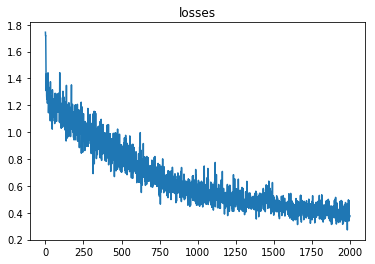

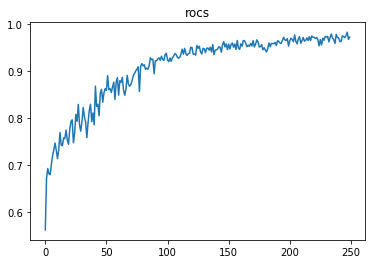

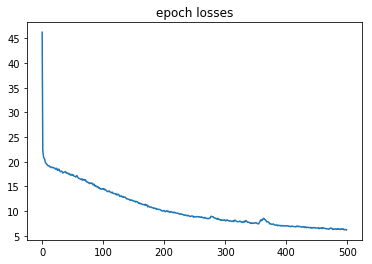

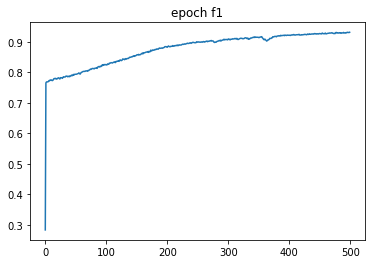

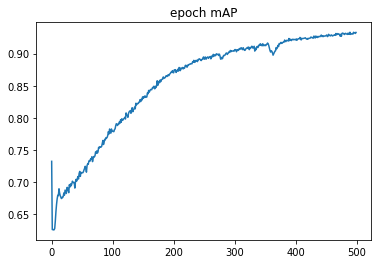

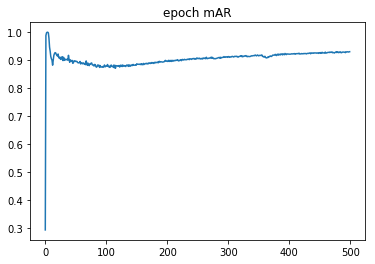

In [12]:
from matplotlib import pyplot as plt

plt.plot(ps_losses)
plt.title('losses')
plt.show()

plt.plot(ps_rocs)
plt.title('rocs')
plt.show()

plt.plot(ps_losses_ep)
plt.title('epoch losses')
plt.show()

plt.plot(ps_f1_ep)
plt.title('epoch f1')
plt.show()

plt.plot(ps_mAP_ep)
plt.title('epoch mAP')
plt.show()

plt.plot(ps_mAR_ep)
plt.title('epoch mAR')
plt.show()

In [10]:
save_res = True

if save_res:
    # directory
    save_dir = 'files_MS_aug_bgr'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    model_path = 'jstars_bgr_ms_aug_ep{}_step{}_b{}.pt'.format(num_epochs, ps_step, bsize)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': ps_model.state_dict(),
            'epoch': ep,
            'step': ps_step,
        }, str(model_path))

    save(model_path)

    # save the AUCs
    auc_path = 'auc_bgr_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    auc_path = os.path.join(save_dir, auc_path)
    np.savetxt(auc_path, np.array(ps_rocs))

    #save the loss vectors
    ep_loss_path = 'losses_ep_bgr_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    ep_loss_path = os.path.join(save_dir, ep_loss_path)
    np.savetxt(ep_loss_path, np.array(ps_losses_ep))

    #save the total loss vector
    loss_path = 'loss_bgr_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    loss_path = os.path.join(save_dir, loss_path)
    np.savetxt(loss_path, np.array(ps_losses))
    
    # save the f1's
    f1_path = 'f1_bgr_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(loss_path, np.array(ps_f1_ep))
    
    # save the f1's
    f1_path = 'f1_bgr_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(f1_path, np.array(ps_f1_ep))
    
    # save the mAPs
    mAP_path = 'mAP_bgr_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAP_path = os.path.join(save_dir, mAP_path)
    np.savetxt(mAP_path, np.array(ps_mAP_ep))
    
    # save the mARs
    mAR_path = 'mAR_bgr_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAR_path = os.path.join(save_dir, mAR_path)
    np.savetxt(mAR_path, np.array(ps_mAR_ep))
  

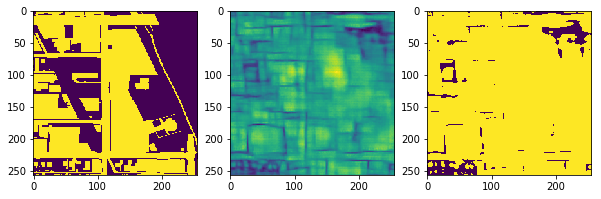

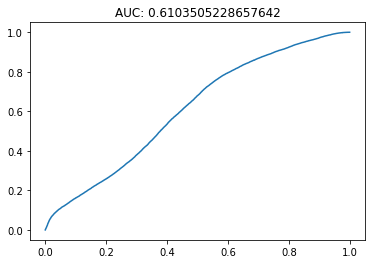

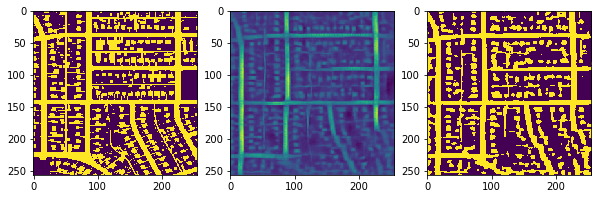

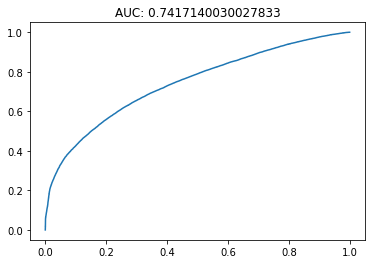

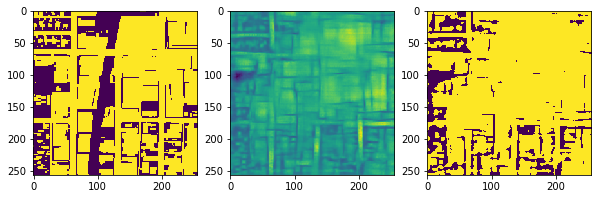

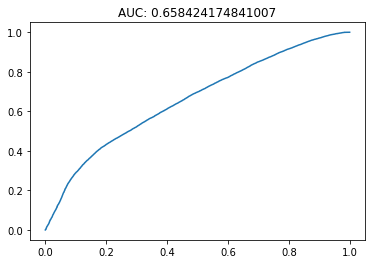

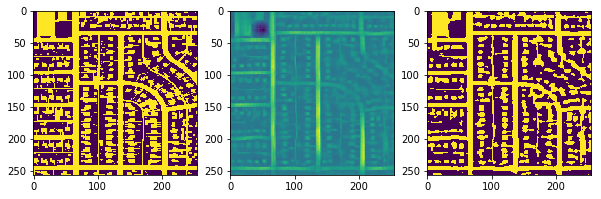

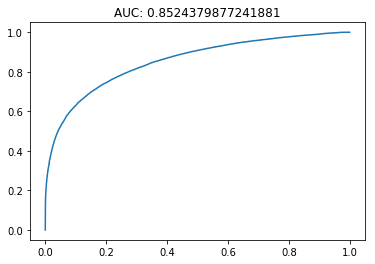

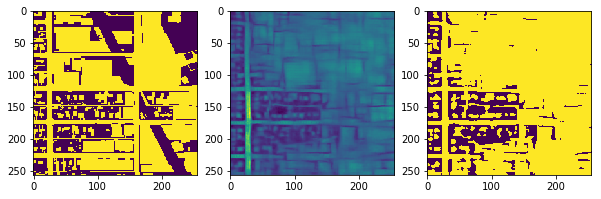

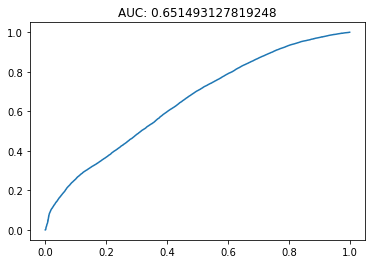

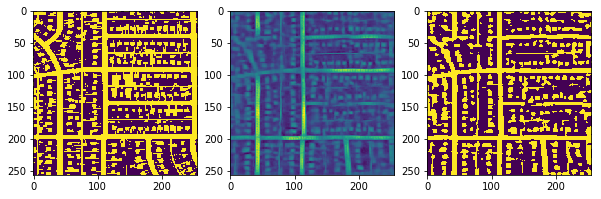

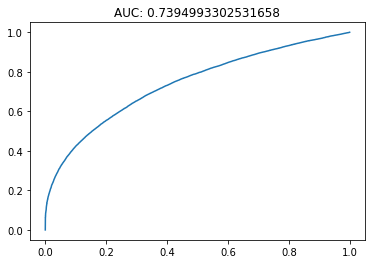

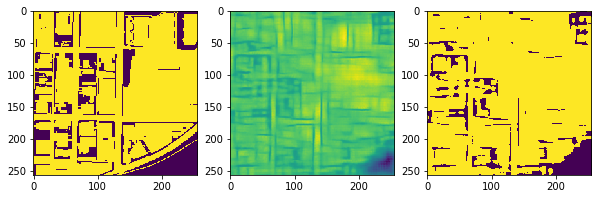

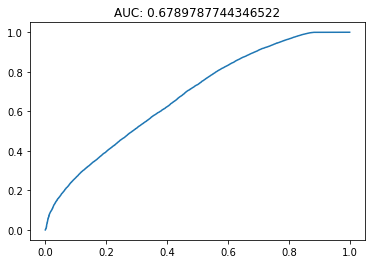

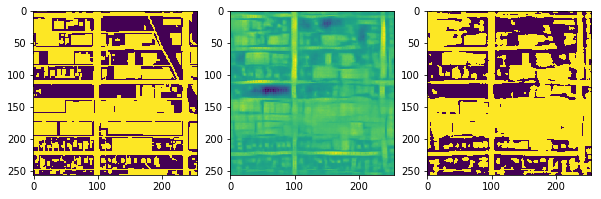

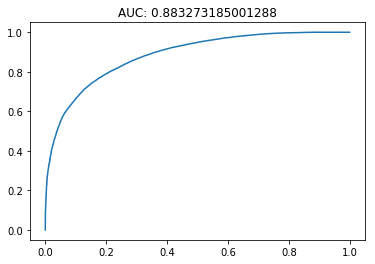

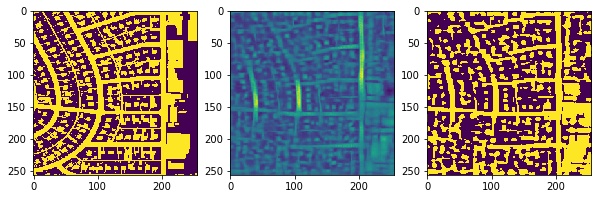

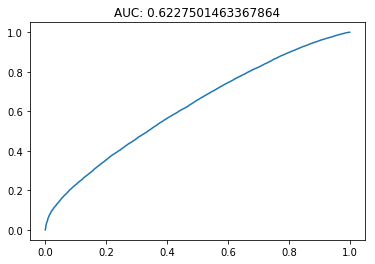

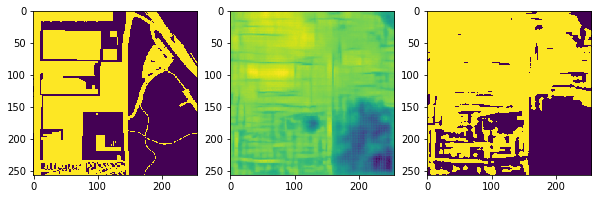

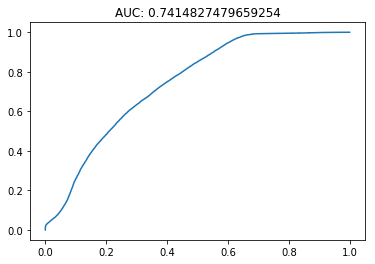

In [11]:
ps_model.eval()
for ind in range(0,10):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    test_im, test_target = ps_test_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    ax[0].imshow(test_target.numpy()[0])

    out = test_out.cpu().detach().numpy()[0][0]
    ax[1].imshow(out)

    ax[2].imshow(out>0)
    #ax[2].imshow(test_im.unsqueeze(0).cpu().detach().numpy()[0][0])
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title('AUC: {}'.format(roc_auc))